In [12]:
import os
os.environ['KERAS_BACKEND']='tensorflow' # 也可以使用 tensorflow
#os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,exception_verbosity=high'
os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_compile'

modifed from https://github.com/martinarjovsky/WassersteinGAN 

In [13]:
import keras.backend as K
K.set_image_data_format('channels_last')
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.losses import binary_crossentropy
from keras.activations import relu
from keras.initializers import RandomNormal
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02)


In [14]:
?K.gradients

In [73]:
def DCGAN_D(isize, nz, nc, ndf, n_extra_layers=0):
    assert isize%2==0
    _ = inputs = Input(shape=(isize, isize, nc))
    _ = Conv2D(filters=ndf, kernel_size=4, strides=2, use_bias=False,
                        padding = "same",
                        kernel_initializer = conv_init, 
                        name = 'initial.conv.{0}-{1}'.format(nc, ndf)             
                        ) (_)
    _ = LeakyReLU(alpha=0.2, name = 'initial.relu.{0}'.format(ndf))(_)
    csize, cndf = isize// 2, ndf
    while csize > 5:
        assert csize%2==0
        in_feat = cndf
        out_feat = cndf*2
        _ = Conv2D(filters=out_feat, kernel_size=4, strides=2, use_bias=False,
                        padding = "same",
                        kernel_initializer = conv_init,
                        name = 'pyramid.{0}-{1}.conv'.format(in_feat, out_feat)             
                        ) (_)
        if 0: # toggle batchnormalization
            _ = BatchNormalization(name = 'pyramid.{0}.batchnorm'.format(out_feat),                                   
                                   momentum=0.9, axis=1, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init, 
                                  )(_, training=1)        
        _ = LeakyReLU(alpha=0.2, name = 'pyramid.{0}.relu'.format(out_feat))(_)
        csize, cndf = (csize+1)//2, cndf*2
    _ = Conv2D(filters=1, kernel_size=csize, strides=1, use_bias=False,
                        kernel_initializer = conv_init,
                        name = 'final.{0}-{1}.conv'.format(cndf, 1)         
                        ) (_)
    outputs = Flatten()(_)
    return Model(inputs=inputs, outputs=outputs)


In [74]:
def DCGAN_G(isize, nz, nc, ngf, n_extra_layers=0):
    cngf= ngf//2
    tisize = isize
    while tisize > 5:
        cngf = cngf * 2
        assert tisize%2==0
        tisize = tisize // 2
    _ = inputs = Input(shape=(nz,))
    _ = Reshape((nz, 1,1))(_)
    _ = Conv2DTranspose(filters=cngf, kernel_size=tisize, strides=1, use_bias=False,
                           kernel_initializer = conv_init, 
                           name = 'initial.{0}-{1}.convt'.format(nz, cngf))(_)
    _ = BatchNormalization(gamma_initializer = gamma_init, momentum=0.9, axis=1, epsilon=1.01e-5,
                               name = 'initial.{0}.batchnorm'.format(cngf))(_, training=1)
    _ = Activation("relu", name = 'initial.{0}.relu'.format(cngf))(_)
    csize, cndf = tisize, cngf
    

    while csize < isize//2:
        in_feat = cngf
        out_feat = cngf//2
        _ = Conv2DTranspose(filters=out_feat, kernel_size=4, strides=2, use_bias=False,
                        kernel_initializer = conv_init, padding="same",
                        name = 'pyramid.{0}-{1}.convt'.format(in_feat, out_feat)             
                        ) (_)
        _ = BatchNormalization(gamma_initializer = gamma_init, 
                                   momentum=0.9, axis=1, epsilon=1.01e-5,
                                   name = 'pyramid.{0}.batchnorm'.format(out_feat))(_, training=1)
        
        _ = Activation("relu", name = 'pyramid.{0}.relu'.format(out_feat))(_)
        csize, cngf = csize*2, cngf//2
    _ = Conv2DTranspose(filters=nc, kernel_size=4, strides=2, use_bias=False,
                        kernel_initializer = conv_init, padding="same",
                        name = 'final.{0}-{1}.convt'.format(cngf, nc)
                        )(_)
    outputs = Activation("tanh", name = 'final.{0}.tanh'.format(nc))(_)
    return Model(inputs=inputs, outputs=outputs)


Parameters

In [90]:
nc = 3
nz = 100
ngf = 64
ndf = 64
n_extra_layers = 0
Diters = 5
λ = 10

imageSize = 32
batchSize = 32
lrD = 1e-4
lrG = 1e-4


print models

In [91]:
DCGAN_G(imageSize, nz, nc, ngf, 0).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 100)               0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 100, 1, 1)         0         
_________________________________________________________________
initial.100-256.convt (Conv2 (None, 103, 4, 256)       4096      
_________________________________________________________________
initial.256.batchnorm (Batch (None, 103, 4, 256)       412       
_________________________________________________________________
initial.256.relu (Activation (None, 103, 4, 256)       0         
_________________________________________________________________
pyramid.256-128.convt (Conv2 (None, 206, 8, 128)       524288    
_________________________________________________________________
pyramid.128.batchnorm (Batch (None, 206, 8, 128)       824       
__________

In [76]:
netD = DCGAN_D(imageSize, nz, nc, ndf, n_extra_layers)
netD.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
initial.conv.3-64 (Conv2D)   (None, 32, 32, 64)        3072      
_________________________________________________________________
initial.relu.64 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
pyramid.64-128.conv (Conv2D) (None, 16, 16, 128)       131072    
_________________________________________________________________
pyramid.128.relu (LeakyReLU) (None, 16, 16, 128)       0         
_________________________________________________________________
pyramid.128-256.conv (Conv2D (None, 8, 8, 256)         524288    
_________________________________________________________________
pyramid.256.relu (LeakyReLU) (None, 8, 8, 256)         0         
__________

In [77]:
netG = DCGAN_G(imageSize, nz, nc, ngf, n_extra_layers)
netG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 100)               0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 100, 1, 1)         0         
_________________________________________________________________
initial.100-512.convt (Conv2 (None, 103, 4, 512)       8192      
_________________________________________________________________
initial.512.batchnorm (Batch (None, 103, 4, 512)       412       
_________________________________________________________________
initial.512.relu (Activation (None, 103, 4, 512)       0         
_________________________________________________________________
pyramid.512-256.convt (Conv2 (None, 206, 8, 256)       2097152   
_________________________________________________________________
pyramid.256.batchnorm (Batch (None, 206, 8, 256)       824       
__________

In [78]:
from keras.optimizers import RMSprop, SGD, Adam

compute Wasserstein loss and  gradient penalty

In [93]:
?K.sum

In [80]:
netD_real_input = Input(shape=(imageSize, imageSize, nc))
noisev = Input(shape=(nz,))
netD_fake_input = netG(noisev)

ϵ_input = K.placeholder(shape=(None, imageSize, imageSize, nc))
netD_mixed_input = Input(shape=(imageSize, imageSize, nc),  tensor=netD_real_input + ϵ_input)


loss_real = K.mean(netD(netD_real_input))
loss_fake = K.mean(netD(netD_fake_input))

grad_mixed = K.gradients(netD(netD_mixed_input), [netD_mixed_input])[0]
norm_grad_mixed = K.sqrt(K.sum(K.square(grad_mixed), axis=[1,2,3]))
grad_penalty = K.mean(K.square(norm_grad_mixed -1))

loss = loss_fake - loss_real + λ * grad_penalty


training_updates = Adam(lr=lrD).get_updates(netD.trainable_weights,[],loss)
netD_train = K.function([netD_real_input, noisev, ϵ_input],
                        [loss_real, loss_fake],    
                        training_updates)

loss for netG

In [81]:
loss = -loss_fake 
training_updates = Adam(lr=lrG).get_updates(netG.trainable_weights,[], loss)
netG_train = K.function([noisev], [loss], training_updates)


Download CIFAR10 if needed

In [36]:
# from PIL import Image
# import numpy as np
# import tarfile

# # Download dataset
# url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
# import os
# import urllib
# from urllib.request import urlretrieve
# def reporthook(a,b,c):
#     print("\rdownloading: %5.1f%%"%(a*b*100.0/c), end="")
# tar_gz = "cifar-10-python.tar.gz"
# if not os.path.isfile(tar_gz):
#         print('Downloading data from %s' % url)
#         urlretrieve(url, tar_gz, reporthook=reporthook)

# import pickle
# train_X=[]
# train_y=[]
# tar_gz = "cifar-10-python.tar.gz"
# with tarfile.open(tar_gz) as tarf:
#     for i in range(1, 6):
#         dataset = "cifar-10-batches-py/data_batch_%d"%i
#         print("load",dataset)
#         with tarf.extractfile(dataset) as f:
#             result = pickle.load(f, encoding='latin1')
#         train_X.extend( result['data'].reshape(-1,3,32,32)/255*2-1)
#         train_y.extend(result['labels'])
#     train_X=np.float32(train_X)
#     train_y=np.int32(train_y)
#     dataset = "cifar-10-batches-py/test_batch"
#     print("load",dataset)
#     with tarf.extractfile(dataset) as f:
#         result = pickle.load(f, encoding='latin1')
#         test_X=np.float32(result['data'].reshape(-1,3,32,32)/255*2-1)
#         test_y=np.int32(result['labels'])
        

In [31]:
import glob
import numpy as np
from PIL import Image
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
file_list = glob.glob("../dataset-download/faces/real/*.png")
train_X = np.array([img_to_array(load_img(fname), "channels_last") for fname in file_list])

In [32]:
def data_generator(batch_size, train_data_directory):
    train_datagen = ImageDataGenerator()
    train_generator = train_datagen.flow_from_directory(train_data_directory,
                                                        target_size=(64, 64),
                                                        batch_size=batch_size,
                                                        class_mode="binary")
    return train_generator

In [43]:
train_generator = data_generator(32, "../dataset-download/faces/")
images = np.empty(shape=(32, 64, 64, 3))
for batch, label in train_generator:
    print("1")
    if batch.shape[0] != 32:
        break
    if images == None:
        images = batch
    else:
        images = np.concatenate((images, batch))
images.shape

Found 521 images belonging to 1 classes.
1
1


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  import sys


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


(544, 64, 64, 3)

also using test_X

In [36]:
?np.concatenate

In [38]:
# train_X = np.concatenate([train_X, test_X])
# train_X = np.concatenate([train_X[:,:,:,::-1], train_X])

NameError: name 'test_X' is not defined

utility to show images

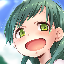

In [61]:
array_to_img(train_X[0])

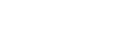

In [62]:
# from IPython.display import display
# def showX(X, rows=1):
#     assert X.shape[0]%rows == 0
#     int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
#     # N*3072 -> N*3*32*32 -> 32 * 32N * 3
#     int_X = np.moveaxis(int_X.reshape(-1,3,32,32), 1, 3)
#     int_X = int_X.reshape(rows, -1, 32, 32,3).swapaxes(1,2).reshape(rows*32,-1, 3)
#     display(Image.fromarray(int_X))
# # 訓練資料， X 的前 20 筆
# showX(train_X[0])
# # print(train_y[:20])
# # name_array = np.array("airplane car bird cat deer dog frog horse boat truck".split(' '))
# # print(name_array[train_y[:20]])

In [92]:
fixed_noise = np.random.normal(size=(batchSize, nz)).astype('float32')
K.gradients

[0/100][10/16][0] Loss_D: 2446.545898 Loss_G: 0.000000 Loss_D_real: 2446.772949 Loss_D_fake 0.227098 257.44668984413147


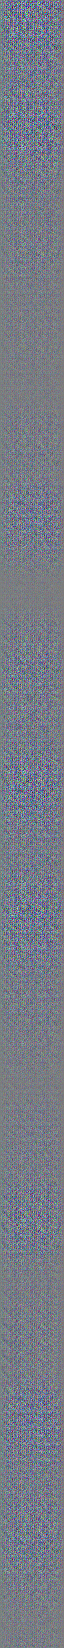

In [86]:
import time
t0 = time.time()
niter = 100
gen_iterations = 0
errG = 0
targetD = np.float32([2] * batchSize + [-2] * batchSize)[:, None]
targetG = np.ones(batchSize, dtype=np.float32)[:, None]
for epoch in range(niter):
    i = 0
    #  每個 epoch 洗牌一下
    np.random.shuffle(train_X)
    batches = train_X.shape[0] // batchSize
    while i < batches:
        if gen_iterations < 25 or gen_iterations % 500 == 0:
            _Diters = 100
        else:
            _Diters = Diters
        j = 0
        while j < _Diters and i < batches:
            j+=1
            real_data = train_X[i*batchSize:(i+1)*batchSize]
            i+=1
            noise = np.random.normal(size=(batchSize, nz))        
            ϵ = real_data.std() * np.random.uniform(-0.5,0.5, size=real_data.shape)
            ϵ *= np.random.uniform(size=(batchSize, 1,1,1))
            errD_real, errD_fake  = netD_train([real_data, noise, ϵ])
            errD = errD_real - errD_fake
        
        print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f'
        % (epoch, niter, i, batches, gen_iterations,errD, errG, errD_real, errD_fake), time.time()-t0)
        fake = netG.predict(fixed_noise)
        display(array_to_img(fake[0]))
        
        noise = np.random.normal(size=(batchSize, nz))        
        errG, = netG_train([noise])
        gen_iterations+=1 
        
        break
    break
        

In [89]:
fake[0].shape

(1648, 64, 3)

In [23]:
real_data = train_X[0*32:1*32]
noise = np.random.normal(size=(32, 128))
ep = real_data.std() * np.random.uniform(-0.5, 0.5, size=real_data.shape)
ep *= np.random.uniform(size=(32, 1, 1, 1))

In [11]:
a = [1, 2, 3, 4, 5, 6]
a[0:141232143]

[1, 2, 3, 4, 5, 6]

In [26]:
ep.shape

(32, 3, 32, 32)

In [30]:
np.float32([2] * 32 + [-2] * 32)[:, None].shape

(64, 1)

In [33]:
train_X.shape[0] // 32

3750

In [35]:
real_data.shape

(32, 3, 32, 32)

In [37]:
if False:
    print("f")
elif False:
    print("t")
else:
    print("e")

e


AttributeError: 'Function' object has no attribute 'save'